In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 80 kB 8.2 MB/s 
     |████████████████████████████████| 209 kB 47.4 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 112 kB 47.4 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
     |████████████████████████████████| 149 kB 37.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=8a21f173e296320001be3cd2b27c8273d5e3871652be11c30ea86b848335218c
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df=pd.read_csv("/content/drive/MyDrive/Amex_data/Training Data_2021.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Amex_data/Test Data_2021.csv")
train_df = train_df.replace(["missing",'na'],np.nan)
test_df = test_df.replace(["missing",'na'],np.nan)

train_df['mvar47'] = train_df['mvar47'].replace('C',0).replace('L',1)
test_df['mvar47'] = test_df['mvar47'].replace('C',0).replace('L',1)

train_df=train_df.astype('float')
test_df=test_df.astype('float')

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

from tqdm import tqdm

from scipy import stats

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier

from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import cross_val_score, cross_validate


train_df = train_df.drop(['application_key'],axis=1)

test_df_copy = test_df.drop(['application_key'],axis=1)



def rows_with_nan(df,thershold):

    res = []

    for s in df.index:

        if df.loc[[s]].isna().sum().sum() >=thershold:

            res.append(s)



    return res



train_nan_rows = rows_with_nan(train_df,40)

#test_nan_rows = rows_with_nan(test_df_copy,40)

train_df = train_df.drop(train_nan_rows,axis=0)



X_train = train_df.iloc[:,train_df.columns!='default_ind']

Y_train = train_df['default_ind']


#cat doubt: mvar28

#Cat_feat = ['mvar16','mvar17','mvar18','mvar19','mvar20','mvar28','mvar34','mvar35','mvar36','mvar37','mvar38','mvar39','mvar43','mvar45','mvar46','mvar47']

cols = list(X_train.columns)

cols.remove('mvar47')



#filling missing values for 'mvar21','mvar22','mvar23','mvar24','mvar25','mvar26'

#filling with mean/median

#filling with knn

#filling with mean

for i in cols:

    X_train[i] = X_train[i].fillna(value=X_train[i].mean())

for i in cols:

    test_df_copy[i] = test_df_copy[i].fillna(value=test_df_copy[i].mean())



#replace outliners with upper and lower value

for i in cols :

    q1 = np.nanpercentile(X_train[i], 25)

    q3 = np.nanpercentile(X_train[i], 75)

    # print(q1, q3)

    IQR = q3-q1

    lwr_bound = q1-(1.5*IQR)

    upr_bound = q3+(1.5*IQR)

    tenth_per = np.nanpercentile(X_train[i], 10)

    ninty_per = np.nanpercentile(X_train[i], 90)

    X_train[i] = np.where(

        X_train[i] > upr_bound,

        ninty_per,

        np.where(

            X_train[i] < lwr_bound,

            tenth_per,

            X_train[i]

        )

    )

for i in cols :

    q1 = np.nanpercentile(test_df_copy[i], 25)

    q3 = np.nanpercentile(test_df_copy[i], 75)

    # print(q1, q3)

    IQR = q3-q1

    lwr_bound = q1-(1.5*IQR)

    upr_bound = q3+(1.5*IQR)

    tenth_per = np.nanpercentile(test_df_copy[i], 10)

    ninty_per = np.nanpercentile(test_df_copy[i], 90)


    test_df_copy[i] = np.where(

        test_df_copy[i] > upr_bound,

        ninty_per,

        np.where(

            test_df_copy[i] < lwr_bound,

            tenth_per,

            test_df_copy[i]

        )

    )


In [ ]:
X_train = X_train.drop('mvar5',axis=1)
test_df_copy = test_df_copy.drop('mvar5',axis=1)

In [ ]:
cor_matrix_train=X_train.corr().abs()

upper_tri_train = cor_matrix_train.where(np.triu(np.ones(cor_matrix_train.shape),k=1).astype(np.bool))

cor_matrix_test=test_df_copy.corr().abs()

upper_tri_test = cor_matrix_test.where(np.triu(np.ones(cor_matrix_test.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri_train.columns if any(upper_tri_train[column] > 0.7)]

print(to_drop)

to_drop = [column for column in upper_tri_test.columns if any(upper_tri_test[column] > 0.7)]

print(to_drop)


X_train = X_train.drop(to_drop,axis=1)

test_df_copy=test_df_copy.drop(to_drop,axis=1)

#normalizing the dataset

for col in cols:

    try:

        X_train[col]=(X_train[col]-X_train[col].min())/(X_train[col].max()-X_train[col].min())

    except KeyError:

        pass

#normalizing the dataset

for col in cols:

    try:

        test_df_copy[col]=(test_df_copy[col]-test_df_copy[col].min())/(test_df_copy[col].max()-test_df_copy[col].min())

    except KeyError:

        pass

['mvar10', 'mvar17', 'mvar18', 'mvar20', 'mvar23', 'mvar26', 'mvar27', 'mvar32', 'mvar37', 'mvar42']
['mvar10', 'mvar17', 'mvar18', 'mvar20', 'mvar23', 'mvar26', 'mvar27', 'mvar32', 'mvar37', 'mvar42']


In [ ]:
# X_train = X_train.drop('application_key',axis=1)
# test_df_copy = test_df.drop('application_key',axis=1)

In [ ]:
X_train = X_train.drop(['application_key','mvar11','mvar15','mvar22','mvar23','mvar30','mvar31','mvar40','mvar41'],axis=1)
test_df_copy = test_df.drop(['application_key','mvar11','mvar15','mvar22','mvar23','mvar30','mvar31','mvar40','mvar41'],axis=1)

In [ ]:
Cat_feat = ['mvar16','mvar17','mvar18','mvar19','mvar20','mvar34','mvar35','mvar36','mvar37','mvar38','mvar39','mvar43','mvar45','mvar46','mvar47_C','mvar47_L']
cols = list(X_train.columns)
for i in Cat_feat:
    cols.remove(i)

In [ ]:
cols.remove('mvar4')
cols.remove('mvar5')

In [ ]:
#replace outliners with upper and lower value
for i in cols :
    q1 = np.nanpercentile(X_train[i], 25)
    q3 = np.nanpercentile(X_train[i], 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    tenth_per = np.nanpercentile(X_train[i], 10)
    ninty_per = np.nanpercentile(X_train[i], 90)

    X_train[i] = np.where(
        X_train[i] > upr_bound,
        ninty_per,
        np.where(
            X_train[i] < lwr_bound,
            tenth_per,
            X_train[i]
        )
    )

In [ ]:
for i in cols :
    q1 = np.nanpercentile(test_df_copy[i], 25)
    q3 = np.nanpercentile(test_df_copy[i], 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    tenth_per = np.nanpercentile(test_df_copy[i], 10)
    ninty_per = np.nanpercentile(test_df_copy[i], 90)

    test_df_copy[i] = np.where(
        test_df_copy[i] > upr_bound,
        ninty_per,
        np.where(
            test_df_copy[i] < lwr_bound,
            tenth_per,
            test_df_copy[i]
        )
    )

In [ ]:
#filling missing values for 'mvar21','mvar22','mvar23','mvar24','mvar25','mvar26'
#filling with mean/median
#filling with knn
#filling with mean
for i in cols+['mvar4','mvar5']:
    X_train[i] = X_train[i].fillna(method='ffill')
for i in cols+['mvar4','mvar5']:
    test_df_copy[i] = test_df_copy[i].fillna(method='ffill')

In [ ]:
X_train.tail()

,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,mvar10,mvar12,mvar13,mvar14,mvar16,mvar17,mvar18,mvar19,mvar20,mvar21,mvar24,mvar25,mvar26,mvar27,mvar28,mvar29,mvar32,mvar33,mvar34,mvar35,mvar36,mvar37,mvar38,mvar39,mvar42,mvar43,mvar44,mvar45,mvar46,mvar47_C,mvar47_L
82995,1748.0,0.3044,0.0,0.0,0.0,0.0,20114.0,5574.0,77386.0,81647.0,18228.9,38049.0,148650.0,1.0,1.0,1.0,3.0,4.0,98.702,90.11,3219.0,8091.0,8091.0,30.0,8091.0,635.0,16.0833,0.0,0.0,11.0,3.0,4.0,0.0,0.04348,13.0,0.48002,0.0,0.0,0.0,1.0
82996,1846.0,0.3044,0.0,0.0,0.0,793.0,18608.0,18608.0,63820.0,29187.0,7863.0,38049.0,79280.0,0.0,0.0,0.0,0.0,0.0,19.885,17.27,3207.0,2342.0,2342.0,1004.0,7969.0,949.0,21.3333,0.0,-1.0,2.0,6.0,1.0,0.0,0.00000,5.0,0.46925,-1.0,0.0,0.0,1.0
82997,1907.0,0.0381,0.0,0.0,0.0,2478.0,24775.0,19820.0,100294.0,79483.0,2968.0,38049.0,99100.0,0.0,0.0,0.0,0.0,0.0,9.967,3.54,2038.0,5049.0,5049.0,30386.0,5536.0,938.0,4.5833,0.0,-1.0,14.0,8.0,0.0,0.0,0.00000,19.0,0.67960,-1.0,0.0,0.0,1.0
82998,1744.0,1.8301,0.0,0.0,0.0,496.0,917.0,496.0,92071.2,2218.0,656.0,4108.0,9910.0,0.0,0.0,0.0,1.0,1.0,9.967,17.70,2488.0,5445.0,5445.0,760.0,6631.0,1139.0,1.5833,0.0,-1.0,1.0,22.0,4.0,0.0,0.09375,3.0,0.45317,-1.0,0.0,0.0,1.0
82999,1832.0,1.5561,0.0,0.0,0.0,1016.0,7928.0,7928.0,92071.2,58977.0,19548.0,38049.0,208110.0,0.0,0.0,0.0,1.0,1.0,44.752,17.92,2390.0,7026.0,7026.0,30386.0,10098.0,1257.0,0.1667,0.0,0.0,7.0,9.0,10.0,0.0,0.00000,18.0,0.83278,0.0,0.0,0.0,1.0


In [ ]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# def calc_vif(X):

#     # Calculating VIF
#     vif = pd.DataFrame()
#     vif["variables"] = X.columns
#     vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

#     return(vif)
# vifs = calc_vif(X_train)

In [ ]:
cor_matrix=X_train.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

In [ ]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7)]
print(to_drop)

['mvar10', 'mvar17', 'mvar18', 'mvar20', 'mvar27', 'mvar32', 'mvar37', 'mvar42', 'mvar47_L']


In [ ]:
X_train = X_train.drop(to_drop,axis=1)
test_df_copy=test_df_copy.drop(to_drop,axis=1)

In [ ]:
X_train.shape, test_df_copy.shape

((83000, 31), (47000, 31))

In [ ]:
#normalizing the dataset
for col in cols+['mvar4','mvar5']:
  try:
    X_train[col]=(X_train[col]-X_train[col].min())/(X_train[col].max()-X_train[col].min())
  except KeyError:
    pass

In [ ]:
#normalizing the dataset
for col in cols+['mvar4','mvar5']:
  try:
    test_df_copy[col]=(test_df_copy[col]-test_df_copy[col].min())/(test_df_copy[col].max()-test_df_copy[col].min())
  except KeyError:
    pass

In [ ]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score,balanced_accuracy_score
#mytrain = mytrain.drop(['mvar22','mvar23','mvar25'],axis=1)
X = X_train
Y = Y_train
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)

In [ ]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((57725, 36), (57725,), (24740, 36), (24740,))

In [ ]:
# lr = LogisticRegression()
# lr.fit(x_train,y_train)
# preds = lr.predict(x_test)
# print("confusion matrix:",confusion_matrix(y_test,preds))
# print("accuracy_score:",accuracy_score(y_test,preds))
# print("recall_score:",recall_score(y_test,preds))
# print("f1_score:",f1_score(y_test,preds))
# print("precision_score:",precision_score(y_test,preds))
# print("balanced_accuracy_score:",balanced_accuracy_score(y_test,preds))

confusion matrix: [[16229  1525]
 [ 4255  2891]]
accuracy_score: 0.7678714859437751
recall_score: 0.4045619927232018
f1_score: 0.5000864902266045
precision_score: 0.6546648550724637
balanced_accuracy_score: 0.6593329283205961


In [ ]:
# preds1 = lr.predict(x_train)
# print("confusion matrix:",confusion_matrix(y_train,preds1))
# print("accuracy_score:",accuracy_score(y_train,preds1))
# print("recall_score:",recall_score(y_train,preds1))
# print("f1_score:",f1_score(y_train,preds1))
# print("precision_score:",precision_score(y_train,preds1))
# print("balanced_accuracy_score:",balanced_accuracy_score(y_train,preds1))

confusion matrix: [[37872  3519]
 [10133  6576]]
accuracy_score: 0.765025817555938
recall_score: 0.39356035669399725
f1_score: 0.49067303387554095
precision_score: 0.6514115898959881
balanced_accuracy_score: 0.6542709372076205


## Using Xgboost

In [ ]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score,balanced_accuracy_score
#mytrain = mytrain.drop(['mvar22','mvar23','mvar25'],axis=1)
X = X_train
Y = Y_train
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)

In [ ]:
X

,mvar1,mvar2,mvar3,mvar4,mvar6,mvar7,mvar8,mvar9,mvar11,mvar12,mvar13,mvar14,mvar15,mvar16,mvar19,mvar21,mvar22,mvar24,mvar25,mvar28,mvar29,mvar30,mvar31,mvar33,mvar34,mvar35,mvar36,mvar38,mvar39,mvar40,mvar41,mvar43,mvar44,mvar45,mvar46,mvar47
0,0.441758,0.543290,0.000000,0.0,0.000000,0.147850,0.018620,0.470326,0.538781,0.402656,0.081948,0.531392,0.625034,1.000000,1.000000,0.717720,0.916641,0.477150,0.340554,0.002008,0.340957,0.000000,0.000000,0.044985,1.0,0.0,0.500000,0.333333,1.0,0.0,1.000000,0.454545,0.615677,1.0,0.0,0.0
1,0.771429,0.265881,0.000000,0.0,0.025895,0.185139,0.183371,0.212438,0.538781,0.047958,0.051595,0.182799,0.625034,0.000000,0.000000,0.562065,0.097207,0.031700,0.239460,1.000000,0.171607,0.549339,0.000000,0.013844,0.0,0.0,0.500000,0.166667,0.0,1.0,0.289101,0.590909,0.615006,1.0,1.0,1.0
2,0.549451,0.131413,0.000000,0.0,0.414681,0.062336,0.394519,0.396479,0.538781,0.437280,0.414025,0.326488,0.625034,0.217686,0.000000,0.433571,0.443419,0.466520,0.412352,0.022017,0.347803,1.000000,0.629477,0.733563,0.0,1.0,0.000000,0.083333,0.0,0.0,0.000000,0.045455,1.000000,1.0,0.0,0.0
3,0.536264,0.072029,0.000000,0.0,0.503173,0.649903,0.286535,0.236695,0.538781,0.000000,0.000000,0.361347,0.625034,0.000000,0.000000,0.433571,0.000000,0.000000,0.304682,0.002995,0.450797,0.549339,1.000000,0.425604,0.0,0.0,0.142857,0.166667,0.0,0.0,0.289101,0.136364,0.502214,0.0,0.0,1.0
4,0.641758,0.003876,0.013201,0.0,0.930693,0.135044,0.317704,0.093054,0.538781,0.141491,0.743200,0.531392,0.980528,0.000000,0.000000,0.154617,0.081256,0.189671,0.186583,0.016027,0.203656,0.549339,0.000000,0.034605,0.0,0.0,0.071429,0.166667,0.0,1.0,0.289101,0.045455,0.921913,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82995,0.556044,0.099980,0.000000,0.0,0.000000,0.494408,0.322331,0.901598,0.027307,1.000000,0.918335,0.637671,0.569843,1.000000,1.000000,0.747456,0.974902,0.595100,0.749825,0.000987,0.608712,1.000000,0.629477,0.664358,0.0,0.0,0.714286,0.333333,0.0,0.0,0.000000,0.590909,0.446441,0.0,0.0,1.0
82996,0.771429,0.346822,0.000000,0.0,0.201320,0.457390,1.000000,0.743546,0.538781,0.492929,0.918335,0.340091,0.625034,0.000000,0.000000,0.149878,0.000000,0.114054,0.747030,0.033042,0.599534,0.549339,0.629477,0.882350,0.0,1.0,0.071429,0.083333,0.0,0.0,0.289101,0.227273,0.434976,1.0,0.0,1.0
82997,0.905495,0.012514,0.000000,0.0,0.629094,0.608977,1.000000,0.983701,0.538781,0.186063,0.918335,0.425114,0.625034,0.000000,0.000000,0.074681,0.443419,0.023379,0.474726,1.000000,0.416491,1.000000,1.000000,0.186851,0.0,1.0,0.928571,0.000000,0.0,1.0,0.000000,0.863636,0.658909,1.0,0.0,1.0
82998,0.547253,0.601097,0.000000,0.0,0.125920,0.022540,0.028682,0.983701,0.538781,0.041124,0.109763,0.042511,0.625034,0.000000,0.333333,0.433571,0.260354,0.116893,0.579548,0.025012,0.498872,1.000000,0.629477,0.062284,0.0,1.0,0.000000,0.333333,0.0,0.0,0.289101,0.136364,0.417857,1.0,0.0,1.0


In [ ]:
import optuna 
import joblib
from optuna import Trial, visualization
from optuna.samplers import TPESampler

def objective(trial: Trial,X,y) -> float:

    param = {
                "n_estimators" : trial.suggest_int('n_estimators', 500, 2000),
                "num_leaves": trial.suggest_int('num_leaves',0,50),
                'max_depth':trial.suggest_int('max_depth', 2, 10),
                'reg_alpha':trial.suggest_loguniform('reg_alpha', 0.01, 5),
                'reg_lambda':trial.suggest_loguniform('reg_lambda', 0.1, 5),
                'min_split_gain ':trial.suggest_loguniform('min_split_gain ',0.1,5),
                'min_child_samples':trial.suggest_int('min_child_samples',0,50),
                'min_child_weight':trial.suggest_loguniform('min_child_weight', 0.01, 5),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.05,0.5),
                'nthread' : -1,
                'scale_pos_weight':2.6
            }
    
    model = LGBMClassifier(device="gpu",**param)
    
    return cross_val_score(model, X, y, cv=3,scoring='roc_auc').mean()
  
study = optuna.create_study(direction='maximize',sampler=TPESampler())
study.optimize(lambda trial : objective(trial,X,Y),n_trials= 10)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

[I 2021-12-15 13:33:42,194] A new study created in memory with name: no-name-e5ad2264-e0f3-450c-a50d-282453a6015d
[W 2021-12-15 13:33:42,945] Trial 0 failed, because the objective function returned nan.
[W 2021-12-15 13:33:43,701] Trial 1 failed, because the objective function returned nan.
[W 2021-12-15 13:33:44,452] Trial 2 failed, because the objective function returned nan.
[W 2021-12-15 13:33:45,195] Trial 3 failed, because the objective function returned nan.
[W 2021-12-15 13:33:45,935] Trial 4 failed, because the objective function returned nan.
[W 2021-12-15 13:33:46,681] Trial 5 failed, because the objective function returned nan.
[W 2021-12-15 13:33:47,425] Trial 6 failed, because the objective function returned nan.
[W 2021-12-15 13:33:48,169] Trial 7 failed, because the objective function returned nan.
[W 2021-12-15 13:33:48,948] Trial 8 failed, because the objective function returned nan.
[W 2021-12-15 13:33:49,700] Trial 9 failed, because the objective function returned n

ValueError: ignored

In [ ]:
from xgboost import XGBClassifier
param = {'n_estimators': 526, 'max_depth': 5, 'reg_alpha': 0, 'reg_lambda': 4, 'min_child_weight': 0, 'gamma': 4, 'learning_rate': 0.05426408985502295, 'colsample_bytree': 0.38,'scale_pos_weight':2.5}
model = XGBClassifier(**param)
#lr = LogisticRegression()
model.fit(x_train,y_train)
preds = model.predict(x_test)
print("confusion matrix:",confusion_matrix(y_test,preds))
print("accuracy_score:",accuracy_score(y_test,preds))
print("recall_score:",recall_score(y_test,preds))
print("f1_score:",f1_score(y_test,preds))
print("precision_score:",precision_score(y_test,preds))
print("balanced_accuracy_score:",balanced_accuracy_score(y_test,preds))

confusion matrix: [[13096  4658]
 [ 2203  4943]]
accuracy_score: 0.7244578313253012
recall_score: 0.6917156451161489
f1_score: 0.5903146832268465
precision_score: 0.5148422039370899
balanced_accuracy_score: 0.7146761170269266


In [ ]:
param = {'n_estimators': 526, 'max_depth': 5, 'reg_alpha': 0, 'reg_lambda': 4, 'min_child_weight': 0, 'gamma': 4, 'learning_rate': 0.05426408985502295, 'colsample_bytree': 0.38,'scale_pos_weight':2.5}
model = XGBClassifier(**param)
#lr = LogisticRegression()
model.fit(X,Y)
preds = model.predict(test_df_copy)

In [ ]:
test_df['default_ind'] = preds
test_df[['application_key','default_ind']].astype(int).to_csv("submission4.csv",index=False,header=False)

## Using Random Forest

In [ ]:
#n_estimators = 50, max_depth=15
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(n_estimators=50,max_depth=15,min_samples_split=2,min_samples_leaf=1),
                                X = x_train, y = y_train, 
                                param_name = 'min_samples_leaf', 
                                param_range = [1,2,3,4,5], cv = 3,scoring = "roc_auc")


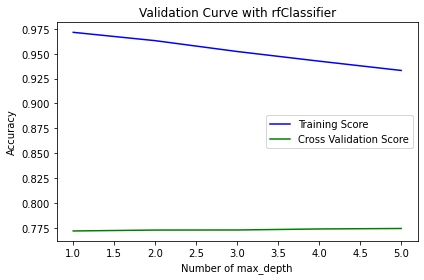

In [ ]:
mean_train_score = np.mean(train_scoreNum, axis = 1)
std_train_score = np.std(train_scoreNum, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_scoreNum, axis = 1)
std_test_score = np.std(test_scoreNum, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot([1,2,3,4,5], mean_train_score,
     label = "Training Score", color = 'b')
plt.plot([1,2,3,4,5], mean_test_score,
   label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with rfClassifier")
plt.xlabel("Number of max_depth")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [ ]:
forestVC = RandomForestClassifier(n_estimators=50,max_depth=15,min_samples_split=2,min_samples_leaf=1) 
modelVC = forestVC.fit(x_train, y_train) 

In [ ]:
preds = modelVC.predict(x_test)
print("confusion matrix:",confusion_matrix(y_test,preds))
print("accuracy_score:",accuracy_score(y_test,preds))
print("recall_score:",recall_score(y_test,preds))
print("f1_score:",f1_score(y_test,preds))
print("precision_score:",precision_score(y_test,preds))
print("balanced_accuracy_score:",balanced_accuracy_score(y_test,preds))

confusion matrix: [[16384  1370]
 [ 4348  2798]]
accuracy_score: 0.7703614457831325
recall_score: 0.3915477190036384
f1_score: 0.49460844970832596
precision_score: 0.6713051823416507
balanced_accuracy_score: 0.6571910049338345


In [ ]:
preds = modelVC.predict(x_train)
print("confusion matrix:",confusion_matrix(y_train,preds))
print("accuracy_score:",accuracy_score(y_train,preds))
print("recall_score:",recall_score(y_train,preds))
print("f1_score:",f1_score(y_train,preds))
print("precision_score:",precision_score(y_train,preds))
print("balanced_accuracy_score:",balanced_accuracy_score(y_train,preds))

confusion matrix: [[41053   338]
 [ 5146 11563]]
accuracy_score: 0.9056110154905336
recall_score: 0.6920222634508348
f1_score: 0.8083187696609576
precision_score: 0.9715990252919923
balanced_accuracy_score: 0.8419281185099841


## Using Lightgbm

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
import optuna 
import joblib
from optuna import Trial, visualization
from optuna.samplers import TPESampler
def objective(trial: Trial,X,y) -> float:
    
    joblib.dump(study, 'study.pkl')

    param = {
                "n_estimators" : trial.suggest_int('n_estimators', 500, 2000),
                "num_leaves": trial.suggest_int('num_leaves',0,50),
                'max_depth':trial.suggest_int('max_depth', 2, 10),
                'reg_alpha':trial.suggest_loguniform('reg_alpha', 0.01, 5),
                'reg_lambda':trial.suggest_loguniform('reg_lambda', 0.1, 5),
                'min_split_gain ':trial.suggest_loguniform('min_split_gain ',0.1,5),
                'min_child_samples':trial.suggest_int('min_child_samples',0,50),
                'min_child_weight':trial.suggest_loguniform('min_child_weight', 0.01, 5),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.05,0.5)
            }
    
    model = LGBMClassifier(**param)
    
    return cross_val_score(model, X, y, cv=3,scoring='roc_auc').mean()
  
study = optuna.create_study(direction='maximize',sampler=TPESampler())
study.optimize(lambda trial : objective(trial,x_train,y_train),n_trials= 10)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

[I 2021-12-08 13:49:32,783] A new study created in memory with name: no-name-84057032-e2bc-47b3-8890-45fa4d11d06d
[I 2021-12-08 13:50:09,333] Trial 0 finished with value: 0.7610047505401436 and parameters: {'n_estimators': 1614, 'num_leaves': 32, 'max_depth': 4, 'reg_alpha': 0.2662089070963447, 'reg_lambda': 0.3558375812889827, 'min_split_gain ': 0.3897623507686775, 'min_child_samples': 2, 'min_child_weight': 0.5097301514414817, 'learning_rate': 0.12519817943726816}. Best is trial 0 with value: 0.7610047505401436.
[I 2021-12-08 13:50:32,199] Trial 1 finished with value: 0.756329531537619 and parameters: {'n_estimators': 1085, 'num_leaves': 14, 'max_depth': 9, 'reg_alpha': 0.057734578446689264, 'reg_lambda': 4.1790078093017025, 'min_split_gain ': 4.036711502716259, 'min_child_samples': 39, 'min_child_weight': 0.048840885518998296, 'learning_rate': 0.2445896913349848}. Best is trial 0 with value: 0.7610047505401436.
[I 2021-12-08 13:50:56,808] Trial 2 finished with value: 0.7752856486977

Best trial: score 0.7803385557894894,
params {'n_estimators': 1855, 'num_leaves': 2, 'max_depth': 10, 'reg_alpha': 0.021789970165365304, 'reg_lambda': 0.45751746262521453, 'min_split_gain ': 1.0176210979535125, 'min_child_samples': 5, 'min_child_weight': 0.3010481694037891, 'learning_rate': 0.11912799020355966}


In [ ]:
param = {'n_estimators': 1855, 'num_leaves': 2, 'max_depth': 10, 'reg_alpha': 0.021789970165365304, 'reg_lambda': 0.45751746262521453, 'min_split_gain ': 1.0176210979535125, 'min_child_samples': 5, 'min_child_weight': 0.3010481694037891, 'learning_rate': 0.11912799020355966}
lgclf = lgb.LGBMClassifier(**param)
lgclf.fit(x_train, y_train)

LGBMClassifier(learning_rate=0.11912799020355966, max_depth=10,
               min_child_samples=5, min_child_weight=0.3010481694037891,
               min_split_gain =1.0176210979535125, n_estimators=1855,
               num_leaves=2, reg_alpha=0.021789970165365304,
               reg_lambda=0.45751746262521453)

In [ ]:
preds = lgclf.predict(x_test)
print("confusion matrix:",confusion_matrix(y_test,preds))
print("accuracy_score:",accuracy_score(y_test,preds))
print("recall_score:",recall_score(y_test,preds))
print("f1_score:",f1_score(y_test,preds))
print("precision_score:",precision_score(y_test,preds))
print("balanced_accuracy_score:",balanced_accuracy_score(y_test,preds))

confusion matrix: [[16298  1456]
 [ 4178  2968]]
accuracy_score: 0.7737349397590362
recall_score: 0.4153372516092919
f1_score: 0.5130509939498704
precision_score: 0.6708860759493671
balanced_accuracy_score: 0.6666637818258243


In [ ]:
test_preds = model.predict(test_df_copy)
test_df['default_ind'] = test_preds
test_df[['application_key','default_ind']].astype(int).to_csv("submission4.csv",index=False,header=False)